In [69]:
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

log_dir = "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/"

import math
from typing import Iterable
import numpy as np


def smooth(scalars, weight, nan_policy: str = "ignore"):
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    """
    last = 0
    num_acc = 0
    if nan_policy != "ignore":
        raise ValueError("input contains NaNs")
    mask = ~np.isnan(scalars)
    valid_idx = np.where(mask)[0]
    smoothed = np.empty(len(scalars))
    smoothed[:] = np.nan
    for next_val, i in zip(scalars[mask], valid_idx):
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed[i] = smoothed_val

    return smoothed

In [15]:
precond = pd.read_csv(
    "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/precond_results_LTP093_20230426-204534.csv"
)
precond["model"] = "precond"
logreg = pd.read_csv(
    "/Users/jrudoler/Library/CloudStorage/Box-Box/JR_CML/pytorch_logs/logreg_results_LTP093_20230426-114900.csv"
)
logreg["model"] = "logreg"

<AxesSubplot:xlabel='session', ylabel='AUC/test'>

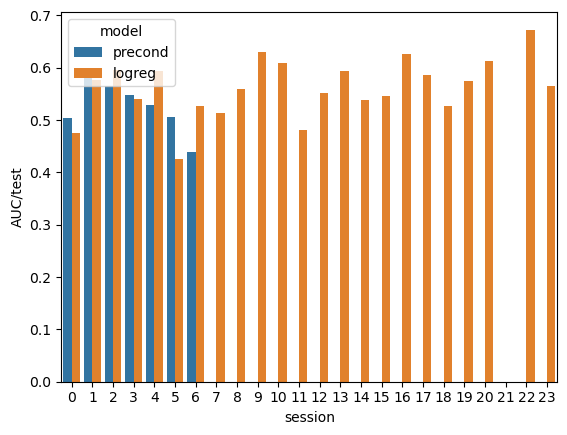

In [16]:
sns.barplot(
    data=pd.concat([precond, logreg]),
    x="session",
    y="AUC/test",
    hue="model",
)

In [17]:
ttest_rel(precond, logreg)

Ttest_relResult(statistic=-0.08497352741166442, pvalue=0.9331714352906815)

In [17]:
import os

In [20]:
files = os.listdir("/Users/jrudoler/data/scalp_features/class_1/")

In [23]:
np.unique([f[4:10] for f in files])

array(['LTP093'], dtype='<U6')

In [23]:
df = []
subs = np.loadtxt("sandbox_subjects.txt", dtype=str)
for subject in subs:
    fname = glob.glob(f"{log_dir}/test_results/precond_test_{subject}_1.000e-03_*")[0]
    df.append(pd.read_csv(fname, index_col=0))
df = pd.concat(df)
df = df.set_index(subs)

/Users/jrudoler/miniforge3/envs/torch/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

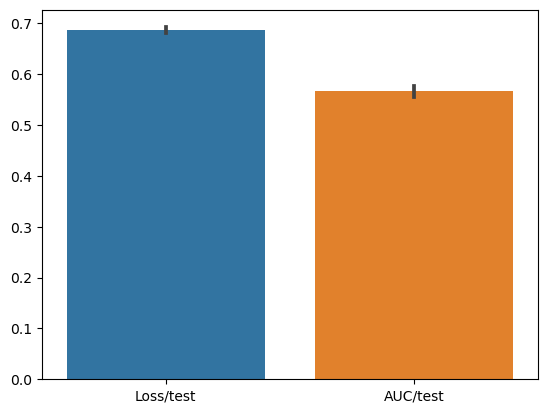

In [24]:
sns.barplot(df)

In [16]:
logreg = pd.read_csv(
    f"{log_dir}test_results/logreg_session_results_LTP093_1.000e+01_20230427-084414.csv"
)

In [18]:
logreg["AUC/test"].mean()

0.5852376093035159

In [19]:
import sklearn

In [20]:
from ptsa.data.timeseries import TimeSeries

In [22]:
data = TimeSeries.from_hdf("/Users/jrudoler/data/scalp_features/LTP093_feats.h5")

/Users/jrudoler/miniforge3/envs/torch/lib/python3.10/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

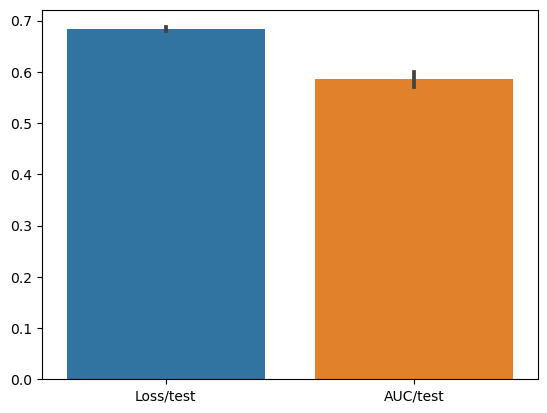

In [26]:
sns.barplot(logreg[["Loss/test", "AUC/test"]])

In [43]:
import glob

files = glob.glob("/Users/jrudoler/Downloads/run*fm*.csv")
fm_training = pd.read_csv(files[0])
for f in files[1:]:
    fm_training = pd.concat([fm_training, pd.read_csv(f)["Value"]], axis=1)

In [166]:
smoothing = 0.95
fm_path = "/Users/jrudoler/Downloads/run-run_fm_20230427-173920-tag-"
fm_loss_val = pd.read_csv(fm_path + "Loss_val.csv")
fm_loss_val.rename(columns={"Value": "Loss"}, inplace=True)
fm_loss_val["Loss_smoothed"] = smooth(fm_loss_val["Loss"], weight=smoothing)
fm_loss_val["type"] = "validation"
fm_auc_val = pd.read_csv(fm_path + "AUC_val.csv")
fm_auc_val.rename(columns={"Value": "AUC"}, inplace=True)
fm_auc_val["type"] = "validation"
fm_auc_val["AUC_smoothed"] = smooth(fm_auc_val["AUC"], weight=smoothing)
fm_loss_train = pd.read_csv(fm_path + "Loss_train.csv")
fm_loss_train.rename(columns={"Value": "Loss"}, inplace=True)
fm_loss_train["type"] = "training"
fm_loss_train["Loss_smoothed"] = smooth(fm_loss_train["Loss"], weight=smoothing)
fm_auc_train = pd.read_csv(fm_path + "AUC_train.csv")
fm_auc_train.rename(columns={"Value": "AUC"}, inplace=True)
fm_auc_train["type"] = "training"
fm_auc_train["AUC_smoothed"] = smooth(fm_auc_train["AUC"], weight=smoothing)
fm_auc = pd.concat([fm_auc_train, fm_auc_val]).sort_values("Step")
fm_loss = pd.concat([fm_loss_train, fm_loss_val]).sort_values("Step")

# tune_auc_all = pd.DataFrame()
# tune_loss_all = pd.DataFrame()
# for subject in np.loadtxt("sandbox_subjects.txt"):
#     tune_loss_val = pd.read_csv(
#         "/Users/jrudoler/Downloads/run-run_fm_20230427-173920-tag-Loss_val.csv"
#     )
#     tune_loss_val.rename(columns={"Value": "Loss"}, inplace=True)
#     tune_loss_val["Loss_smoothed"] = smooth(tune_loss_val["Loss"], weight=smoothing)
#     tune_loss_val["type"] = "validation"
#     tune_auc_val = pd.read_csv(
#         "/Users/jrudoler/Downloads/run-run_fm_20230427-173920-tag-AUC_val.csv"
#     )
#     tune_auc_val.rename(columns={"Value": "AUC"}, inplace=True)
#     tune_auc_val["type"] = "validation"
#     tune_auc_val["AUC_smoothed"] = smooth(tune_auc_val["AUC"], weight=smoothing)
#     tune_loss_train = pd.read_csv(
#         "/Users/jrudoler/Downloads/run-run_fm_20230427-173920-tag-Loss_train.csv"
#     )
#     tune_loss_train.rename(columns={"Value": "Loss"}, inplace=True)
#     tune_loss_train["type"] = "training"
#     tune_loss_train["Loss_smoothed"] = smooth(tune_loss_train["Loss"], weight=smoothing)
#     tune_auc_train = pd.read_csv(
#         "/Users/jrudoler/Downloads/run-run_fm_20230427-173920-tag-AUC_train.csv"
#     )
#     tune_auc_train.rename(columns={"Value": "AUC"}, inplace=True)
#     tune_auc_train["type"] = "training"
#     tune_auc_train["AUC_smoothed"] = smooth(tune_auc_train["AUC"], weight=smoothing)
#     tune_auc = pd.concat([fm_auc_train, fm_auc_val]).sort_values("Step")
#     tune_loss = pd.concat([fm_loss_train, fm_loss_val]).sort_values("Step")
#     tune_auc["subject"], tune_loss["subject"] = subject, subject
#     tune_auc_all.append(tune_auc)
#     tune_loss_all.append(tune_loss)

subject = "LTP299"
tune_path = f"/Users/jrudoler/Downloads/run-run_tune_{subject}_20230428-105034-tag-"
tune_loss_val = pd.read_csv(tune_path + "Loss_val.csv")
tune_loss_val.rename(columns={"Value": "Loss"}, inplace=True)
tune_loss_val["Loss_smoothed"] = smooth(tune_loss_val["Loss"], weight=smoothing)
tune_loss_val["type"] = "validation"
tune_auc_val = pd.read_csv(tune_path + "AUC_val.csv")
tune_auc_val.rename(columns={"Value": "AUC"}, inplace=True)
tune_auc_val["type"] = "validation"
tune_auc_val["AUC_smoothed"] = smooth(tune_auc_val["AUC"], weight=smoothing)
tune_loss_train = pd.read_csv(tune_path + "Loss_train.csv")
tune_loss_train.rename(columns={"Value": "Loss"}, inplace=True)
tune_loss_train["type"] = "training"
tune_loss_train["Loss_smoothed"] = smooth(tune_loss_train["Loss"], weight=smoothing)
tune_auc_train = pd.read_csv(tune_path + "AUC_train.csv")
tune_auc_train.rename(columns={"Value": "AUC"}, inplace=True)
tune_auc_train["type"] = "training"
tune_auc_train["AUC_smoothed"] = smooth(tune_auc_train["AUC"], weight=smoothing)
tune_auc = pd.concat([tune_auc_train, tune_auc_val]).sort_values("Step")
tune_loss = pd.concat([tune_loss_train, tune_loss_val]).sort_values("Step")

Text(0.5, 0, 'Training Step')

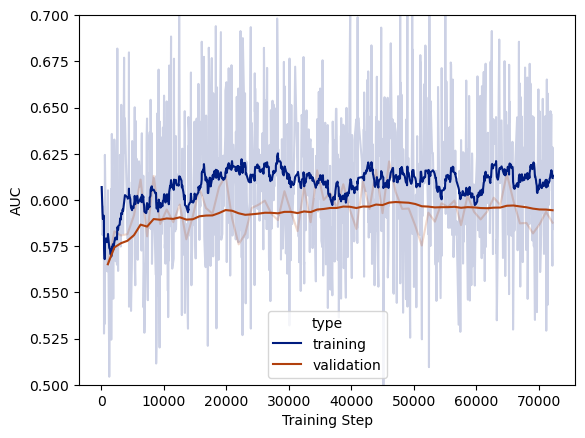

In [100]:
sns.lineplot(fm_auc, x="Step", y="AUC", hue="type", alpha=0.2, palette="dark")
sns.lineplot(
    fm_auc, x="Step", y="AUC_smoothed", hue="type", alpha=1, palette="dark", legend=None
)
plt.ylim(0.5, 0.7)
plt.xlabel("Training Step")

<AxesSubplot:xlabel='Step', ylabel='AUC'>

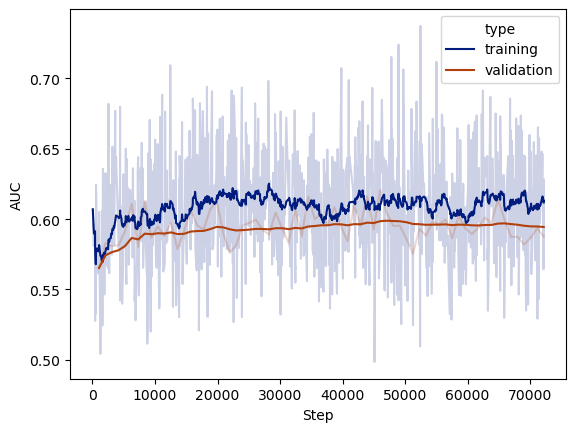

In [95]:
sns.lineplot(tune_auc, x="Step", y="AUC", hue="type", alpha=0.2, palette="dark")
sns.lineplot(
    tune_auc,
    x="Step",
    y="AUC_smoothed",
    hue="type",
    alpha=1,
    palette="dark",
    legend=None,
)

In [ ]:
plt.subplots()

<AxesSubplot:xlabel='Step', ylabel='AUC'>

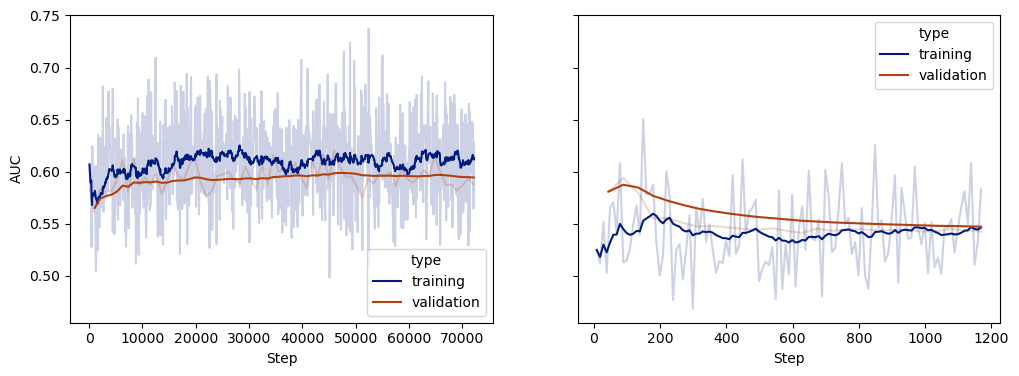

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=False)
sns.lineplot(fm_auc, x="Step", y="AUC", hue="type", alpha=0.2, palette="dark", ax=ax[0])
sns.lineplot(
    fm_auc,
    x="Step",
    y="AUC_smoothed",
    hue="type",
    alpha=1,
    palette="dark",
    legend=None,
    ax=ax[0],
)
sns.lineplot(
    tune_auc, x="Step", y="AUC", hue="type", alpha=0.2, palette="dark", ax=ax[1]
)
sns.lineplot(
    tune_auc,
    x="Step",
    y="AUC_smoothed",
    hue="type",
    alpha=1,
    palette="dark",
    legend=None,
    ax=ax[1],
)
plt.savefig()

In [151]:
import tbparse

smoothing = 0.9

In [255]:
fm_parser = tbparse.SummaryReader(
    "/Users/jrudoler/Box/JR_CML/pytorch_logs/precondition_fm/run_fm_20230427-173920/",
    pivot=True,
    extra_columns={"dir_name"},
)
fm_data = fm_parser.scalars
fm_data["subject"] = fm_data["dir_name"].str[9:15]
fm_train_loss = fm_data.dropna(subset=["Loss/train"])
fm_train_loss["Loss/train smoothed"] = smooth(
    fm_train_loss["Loss/train"], weight=smoothing
)
fm_val_loss = fm_data.dropna(subset=["Loss/val"])
fm_val_loss["Loss/val smoothed"] = smooth(fm_val_loss["Loss/val"], weight=smoothing)
fm_train_auc = fm_data.dropna(subset=["AUC/train"])
fm_train_auc["AUC/train smoothed"] = smooth(fm_train_auc["AUC/train"], weight=smoothing)
fm_val_auc = fm_data.dropna(subset=["AUC/val"])
fm_val_auc["AUC/val smoothed"] = smooth(fm_val_auc["AUC/val"], weight=smoothing)

/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/3962142221.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_train_loss["Loss/train smoothed"] = smooth(
/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/3962142221.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_val_loss["Loss/val smoothed"] = smooth(fm_val_loss["Loss/val"], weight=smoothing)
/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/3962142221.py:15: SettingWithCopyWarning: 
A value is trying 

In [257]:
tune_parser = tbparse.SummaryReader(
    "/Users/jrudoler/Box/JR_CML/pytorch_logs/precondition_tune/",
    pivot=True,
    extra_columns={"dir_name"},
)
tune_data = tune_parser.scalars
tune_data["subject"] = tune_data["dir_name"].str[9:15]
# tune_data['dir_name'].str[-6:].unique()
# run_str = "105034" # weight decay 1.0
run_str = "221632"  # 1e-3
# run_str = "191343" # 1e-6
# run_str = "115620" # small dataset, 1e-3
this_tune_data = tune_data[tune_data.dir_name.str.contains(run_str)]
## Test Performance ##
test_performance = this_tune_data.dropna(subset=["AUC/test"])
## Traces ##
tune_train_loss = this_tune_data.dropna(subset=["Loss/train"])
tune_train_loss["Loss/train smoothed"] = smooth(
    tune_train_loss["Loss/train"], weight=smoothing
)
tune_val_loss = this_tune_data.dropna(subset=["Loss/val"])
tune_val_loss["Loss/val smoothed"] = smooth(tune_val_loss["Loss/val"], weight=smoothing)
tune_train_auc = this_tune_data.dropna(subset=["AUC/train"])
tune_train_auc["AUC/train smoothed"] = smooth(
    tune_train_auc["AUC/train"], weight=smoothing
)
tune_val_auc = this_tune_data.dropna(subset=["AUC/val"])
tune_val_auc["AUC/val smoothed"] = smooth(tune_val_auc["AUC/val"], weight=smoothing)

/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/905371319.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tune_train_loss["Loss/train smoothed"] = smooth(
/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/905371319.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tune_val_loss["Loss/val smoothed"] = smooth(tune_val_loss["Loss/val"], weight=smoothing)
/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/905371319.py:24: SettingWithCopyWarning: 
A value is try

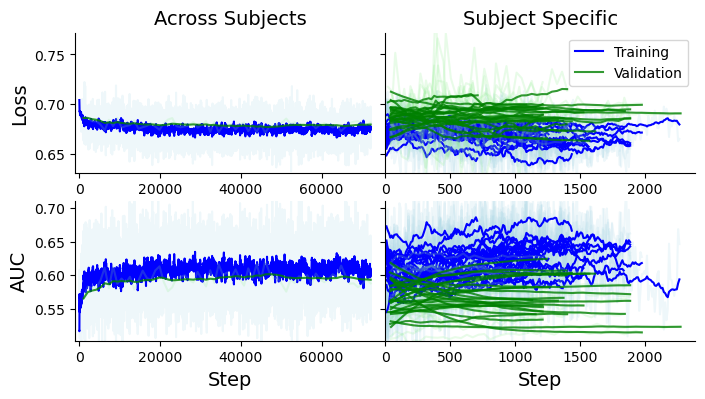

In [272]:
fig, ax = plt.subplots(2, 2, figsize=(8, 4), sharey="row", sharex=False)
# ax = ax.ravel()
sns.lineplot(
    data=fm_train_loss,
    x="step",
    y="Loss/train",
    color="lightblue",
    estimator=None,
    alpha=0.2,
    ax=ax[0, 0],
)
sns.lineplot(
    data=fm_train_loss,
    x="step",
    y="Loss/train smoothed",
    color="blue",
    estimator=None,
    alpha=1,
    ax=ax[0, 0],
)
sns.lineplot(
    data=fm_val_loss,
    x="step",
    y="Loss/val",
    color="lightgreen",
    estimator=None,
    alpha=0.2,
    ax=ax[0, 0],
)
sns.lineplot(
    data=fm_val_loss,
    x="step",
    y="Loss/val smoothed",
    color="green",
    estimator=None,
    alpha=0.8,
    ax=ax[0, 0],
)
ax[0, 0].set_xlim(-1000, None)
ax[0, 1].legend(
    handles=[ax[0, 0].get_children()[1], ax[0, 0].get_children()[3]],
    loc="upper right",
    labels=["Training", "Validation"],
)

sns.lineplot(
    data=tune_train_loss,
    x="step",
    y="Loss/train",
    color="lightblue",
    units="subject",
    estimator=None,
    alpha=0.2,
    ax=ax[0, 1],
)
sns.lineplot(
    data=tune_train_loss,
    x="step",
    y="Loss/train smoothed",
    color="blue",
    units="subject",
    estimator=None,
    alpha=1,
    ax=ax[0, 1],
)
sns.lineplot(
    data=tune_val_loss,
    x="step",
    y="Loss/val",
    color="lightgreen",
    units="subject",
    estimator=None,
    alpha=0.2,
    ax=ax[0, 1],
)
sns.lineplot(
    data=tune_val_loss,
    x="step",
    y="Loss/val smoothed",
    color="green",
    units="subject",
    estimator=None,
    alpha=0.8,
    ax=ax[0, 1],
)
ax[0, 1].set_xlim(0, None)

ax[0, 0].set_ylabel("Loss", fontsize=14)
ax[0, 0].set_title("Across Subjects", fontsize=14)
ax[0, 1].set_title("Subject Specific", fontsize=14)
ax[0, 0].set_xlabel("Step", fontsize=14)
ax[0, 1].set_xlabel("Step", fontsize=14)
plt.subplots_adjust(wspace=0)
ax[0, 0].spines[["right", "top"]].set_visible(False)
ax[0, 1].spines[["right", "top"]].set_visible(False)
ax[0, 0].margins(None, -0.15)

sns.lineplot(
    data=fm_train_auc,
    x="step",
    y="AUC/train",
    color="lightblue",
    estimator=None,
    alpha=0.2,
    ax=ax[1, 0],
)
sns.lineplot(
    data=fm_train_auc,
    x="step",
    y="AUC/train smoothed",
    color="blue",
    estimator=None,
    alpha=1,
    ax=ax[1, 0],
)
sns.lineplot(
    data=fm_val_auc,
    x="step",
    y="AUC/val",
    color="lightgreen",
    estimator=None,
    alpha=0.2,
    ax=ax[1, 0],
)
sns.lineplot(
    data=fm_val_auc,
    x="step",
    y="AUC/val smoothed",
    color="green",
    estimator=None,
    alpha=0.8,
    ax=ax[1, 0],
)
ax[1, 0].set_xlim(-1000, None)

sns.lineplot(
    data=tune_train_auc,
    x="step",
    y="AUC/train",
    color="lightblue",
    units="subject",
    estimator=None,
    alpha=0.2,
    ax=ax[1, 1],
)
sns.lineplot(
    data=tune_train_auc,
    x="step",
    y="AUC/train smoothed",
    color="blue",
    units="subject",
    estimator=None,
    alpha=1,
    ax=ax[1, 1],
)
sns.lineplot(
    data=tune_val_auc,
    x="step",
    y="AUC/val",
    color="lightgreen",
    units="subject",
    estimator=None,
    alpha=0.2,
    ax=ax[1, 1],
)
sns.lineplot(
    data=tune_val_auc,
    x="step",
    y="AUC/val smoothed",
    color="green",
    units="subject",
    estimator=None,
    alpha=0.8,
    ax=ax[1, 1],
)
ax[1, 1].set_xlim(0, None)

ax[1, 0].set_ylabel("AUC", fontsize=14)
ax[1, 0].set_xlabel("Step", fontsize=14)
ax[1, 1].set_xlabel("Step", fontsize=14)
plt.subplots_adjust(wspace=0)
ax[1, 0].spines[["right", "top"]].set_visible(False)
ax[1, 1].spines[["right", "top"]].set_visible(False)
ax[1, 0].margins(None, -0.15)

plt.savefig("training_traces.pdf", dpi=200, bbox_inches="tight")

In [6]:
import numpy as np
from dask.distributed import Client, progress
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [7]:
client = Client()

2023-04-29 23:46:22,864 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/dask-worker-space/worker-8dsqr0om', purging
2023-04-29 23:46:22,865 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/dask-worker-space/worker-b_r3xkv_', purging
2023-04-29 23:46:22,865 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/dask-worker-space/worker-yv42h2i7', purging
2023-04-29 23:46:22,866 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/dask-worker-space/worker-yyi9p92u', purging


In [226]:
from sklearn.metrics import roc_auc_score


def fit_and_score_model(subject):
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from ptsa.data.timeseries import TimeSeries
    from sklearn.metrics import roc_auc_score

    model = LogisticRegression(
        C=7.2e-4, class_weight="balanced", solver="liblinear", max_iter=1000
    )
    data = TimeSeries.from_hdf(
        f"/Users/jrudoler/data/scalp_features/{subject}_feats.h5"
    )
    holdout_query = "session in [5, 10, 15, 20]"
    train_query = "session not in [5, 10, 15, 20]"
    model.fit(
        data.query({"event": train_query}),
        data.query({"event": train_query})["recalled"].values,
    )
    pred = model.predict_proba(data.query({"event": holdout_query}))
    auc = roc_auc_score(
        y_score=pred[:, 1],
        y_true=data.query({"event": holdout_query})["recalled"].values,
    )
    results = {"subject": subject, "AUC": auc}
    return results


def fit_and_score_model_smalldata(subject):
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from ptsa.data.timeseries import TimeSeries
    from sklearn.metrics import roc_auc_score

    model = LogisticRegression(
        C=7.2e-4, class_weight="balanced", solver="liblinear", max_iter=1000
    )
    data = TimeSeries.from_hdf(
        f"/Users/jrudoler/data/scalp_features/{subject}_feats.h5"
    )
    holdout_query = "session in [3, 4, 5]"
    train_query = "session in [0, 1, 2]"
    model.fit(
        data.query({"event": train_query}),
        data.query({"event": train_query})["recalled"].values,
    )
    pred = model.predict_proba(data.query({"event": holdout_query}))
    auc = roc_auc_score(
        y_score=pred[:, 1],
        y_true=data.query({"event": holdout_query})["recalled"].values,
    )
    results = {"subject": subject, "AUC": auc}
    return results

In [227]:
sandbox_subjects = np.loadtxt("sandbox_subjects.txt", dtype=str)
# results = client.map(fit_and_score_model, sandbox_subjects)

In [228]:
results = []
small_data_results = []
for subject in sandbox_subjects:
    results.append(fit_and_score_model(subject))
    small_data_results.append(fit_and_score_model_smalldata(subject))

In [282]:
sklearn_results = pd.DataFrame(results).sort_values("subject")
sklearn_results_smalldata = pd.DataFrame(small_data_results).sort_values("subject")
sklearn_results["type"] = "Logistic Regression"
sklearn_results_smalldata["type"] = "Logistic Regression"

In [244]:
small_tune_data = tune_data[tune_data.dir_name.str.contains("115620")]
## Test Performance ##
small_test_performance = small_tune_data.dropna(subset=["AUC/test"])
## Traces ##
small_tune_train_loss = small_tune_data.dropna(subset=["Loss/train"])
small_tune_train_loss["Loss/train smoothed"] = smooth(
    small_tune_train_loss["Loss/train"], weight=smoothing
)
small_tune_val_loss = small_tune_data.dropna(subset=["Loss/val"])
small_tune_val_loss["Loss/val smoothed"] = smooth(
    small_tune_val_loss["Loss/val"], weight=smoothing
)

/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/493208468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_tune_train_loss["Loss/train smoothed"] = smooth(
/var/folders/z6/n4lxhx6s7zl_h8byjj8vr5kh0000gn/T/ipykernel_6922/493208468.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_tune_val_loss["Loss/val smoothed"] = smooth(small_tune_val_loss["Loss/val"], weight=smoothing)


In [290]:
precond_results = test_performance.rename(columns={"AUC/test": "AUC"})[
    ["subject", "AUC"]
].sort_values("subject")
precond_results["type"] = "Preconditioning Network"
combined_results = pd.concat([sklearn_results, precond_results])
combined_results = combined_results.sort_values(["type", "subject"])
small_precond_results = small_test_performance.rename(columns={"AUC/test": "AUC"})[
    ["subject", "AUC"]
].sort_values("subject")
small_precond_results["type"] = "Preconditioning Network"
small_combined_results = pd.concat([sklearn_results_smalldata, small_precond_results])
small_combined_results = combined_results.sort_values(["type", "subject"])

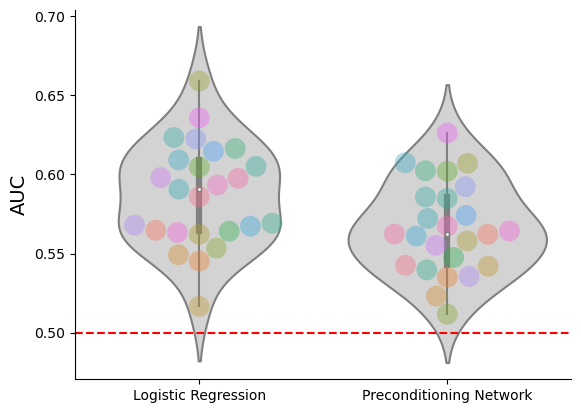

In [302]:
fig, ax = plt.subplots(1, 1, sharex=False, sharey=True)
sns.swarmplot(
    data=combined_results,
    x="type",
    y="AUC",
    # dodge=True,
    size=15,
    hue="subject",
    legend=None,
    alpha=0.4,
    ax=ax,
)
sns.violinplot(
    data=combined_results, x="type", y="AUC", color="lightgray", inner="box", ax=ax
)
plt.xlabel("")
plt.ylabel("AUC", fontsize=14)
ax.spines[["right", "top"]].set_visible(False)
ax.axhline(0.5, color="red", ls="--")

# sns.swarmplot(
#     data=combined_results,
#     x="type",
#     y="AUC",
#     # dodge=True,
#     size=15,
#     hue="subject",
#     legend=None,
#     ax=ax[1]
# )
# sns.violinplot(data=combined_results, x="type", y="AUC", color="lightgray", inner=None, ax=ax[1])
# plt.xlabel("")
# plt.ylabel("AUC", fontsize=14)
# ax[1].spines[["right", "top"]].set_visible(False)
plt.savefig("precond_logreg_comparison.pdf", dpi=200, bbox_inches="tight")

In [304]:
from scipy.stats import ttest_1samp, ttest_rel

ttest_1samp(sklearn_results["AUC"], 0.5)

Ttest_1sampResult(statistic=13.308070086996825, pvalue=1.426061421155924e-12)

In [303]:
ttest_1samp(precond_results["AUC"], 0.5)

Ttest_1sampResult(statistic=11.43643805540547, pvalue=3.360681219007207e-11)

In [284]:
ttest_rel(sklearn_results["AUC"], precond_results["AUC"])

Ttest_relResult(statistic=5.643232378525356, pvalue=8.242552185431301e-06)

In [291]:
ttest_rel(sklearn_results_smalldata["AUC"], small_precond_results["AUC"])

Ttest_relResult(statistic=2.5063288249579303, pvalue=0.019379084299359944)